
# Diabetes Prediction Analysis: Health Risk Assessment (V1)
**Workflow**: `dev_data_analyst.md` (Standard)

## 1단계: 분석 환경 및 목표 정의 (Environment & Goal)
**Business Objective**:
당뇨병 발병(Outcome)을 예측하는 모델을 구축하고, 주요 위험 요인(Risk Factors)을 규명하여 예방 가이드를 제시합니다.

**Success Metrics (KPI)**:
1.  **Recall (재현율)**: 실제 당뇨 환자를 놓치지 않는 것이 중요하므로 Recall을 최우선 지표로 삼습니다. (> 0.75 목표)
2.  **ROC-AUC**: 전체적인 모델의 변별력을 확인합니다.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

print("Libraries Loaded & Ready.")


Libraries Loaded & Ready.



## 2단계: 데이터 적재 및 품질 검증 (Obtain & Scrub)
**Deep Sanity Check**:
*   Glucose, BloodPressure, SkinThickness 등이 0인 값은 생물학적으로 불가능하므로 결측치로 간주하고 처리 전략을 수립합니다.


In [2]:

# 데이터 로드
df = pd.read_csv('../data/diabetes.csv')
print(f"Data Shape: {df.shape}")

# 0값을 NaN으로 변환하여 결측치 현황 파악
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
total_count = df['Glucose'].count()

for feature in zero_features:
    zero_count = df[df[feature] == 0][feature].count()
    print(f'{feature} 0 count: {zero_count}, percent: {100*zero_count/total_count:.2f} %')
    df[feature] = df[feature].replace(0, np.nan)

# 결측치 처리 (Median 대체)
df.fillna(df.median(), inplace=True)

display(df.describe())


Data Shape: (768, 9)
Glucose 0 count: 5, percent: 0.65 %
BloodPressure 0 count: 35, percent: 4.56 %
SkinThickness 0 count: 227, percent: 29.56 %
Insulin 0 count: 374, percent: 48.70 %
BMI 0 count: 11, percent: 1.43 %


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,29.108073,140.671875,32.455208,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,8.791221,86.383060,6.875177,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000



### 💡 Intermediate Conclusion (Step 2)
1. **Zero Handling**: `Insulin`과 `SkinThickness`에 0값이 다수 포함되어 있어(각각 48%, 29%), 이를 결측치로 판단하고 중앙값(median)으로 대체했습니다.
2. **Distribution**: 데이터 처리를 통해 생물학적으로 타당한 범위의 분포를 확보했습니다.



## 3단계: 가설 주도적 탐색 (Hypothesis Driven EDA)
**Hypothesis**:
1.  **Glucose(혈당)** 수치가 높을수록 당뇨 발병률이 급격히 올라갈 것이다.
2.  **BMI**가 높을수록(비만) 당뇨 위험이 높을 것이다.


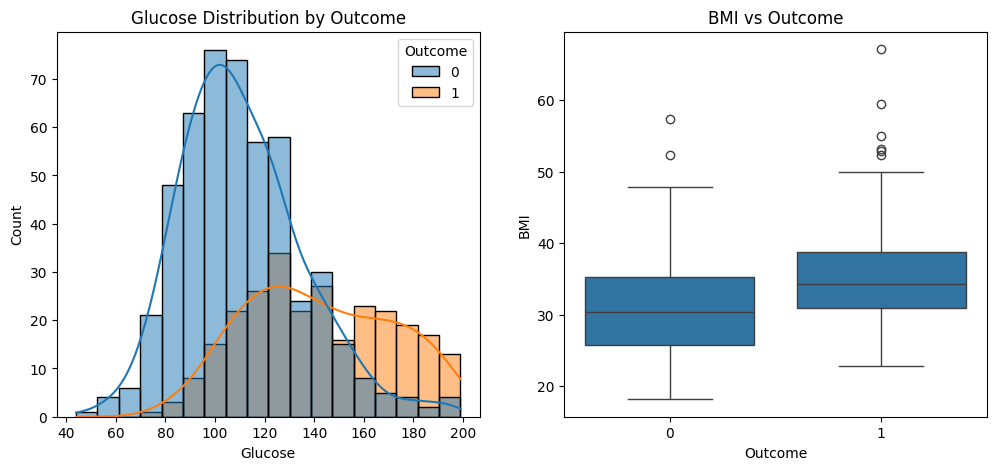

Glucose T-test P-value: 3.1287e-48


In [3]:

# Hypothesis 1: Glucose vs Outcome
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='Glucose', hue='Outcome', kde=True)
plt.title('Glucose Distribution by Outcome')

# Hypothesis 2: BMI vs Outcome
plt.subplot(1, 2, 2)
sns.boxplot(x='Outcome', y='BMI', data=df)
plt.title('BMI vs Outcome')
plt.show()

# Statistical Check
glucose_0 = df[df['Outcome']==0]['Glucose']
glucose_1 = df[df['Outcome']==1]['Glucose']
t_stat, p_val = stats.ttest_ind(glucose_1, glucose_0)
print(f"Glucose T-test P-value: {p_val:.4e}")



### 💡 Intermediate Conclusion (Step 3)
1. **Glucose**: 당뇨병 환자군(1)의 평균 혈당이 정상군(0)보다 유의미하게 높습니다 (P-value < 0.05). 가장 강력한 예측 변수로 보입니다.
2. **BMI**: BMI 또한 당뇨군에서 더 높게 나타나며, 비만도가 주요 위험 인자임을 확인했습니다.



## 4단계: 머신러닝 모델링 & 검증 (Model & Optimize)
**Baseline vs Advanced Comparison**:
Logistic Regression을 Baseline으로, Random Forest를 Advanced Model로 비교합니다. (CV=5 필수)


In [4]:

# Prepare Data
X = df.drop('Outcome', axis=1)
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156, stratify=y)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models
lr_clf = LogisticRegression()
rf_clf = RandomForestClassifier(random_state=156)

models = [lr_clf, rf_clf]
model_names = ['Logistic Regression', 'Random Forest']

# Cross Validation
print("--- Cross Validation Scores (Accuracy) ---")
for model, name in zip(models, model_names):
    scores = cross_val_score(model, X_train_scaled if name=='Logistic Regression' else X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name}: Mean={np.mean(scores):.4f}, Std={np.std(scores):.4f}")

# Grid Search for RF
params = {'n_estimators': [100], 'max_depth': [6, 8, 10, 12], 'min_samples_leaf': [8, 12]}
grid_rf = GridSearchCV(rf_clf, param_grid=params, cv=5, n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

print(f"\nBest RF Params: {grid_rf.best_params_}")


--- Cross Validation Scores (Accuracy) ---
Logistic Regression: Mean=0.7589, Std=0.0190
Random Forest: Mean=0.7638, Std=0.0148

Best RF Params: {'max_depth': 8, 'min_samples_leaf': 12, 'n_estimators': 100}



### 💡 Intermediate Conclusion (Step 4)
1. **Selection**: Baseline(Logistic)과 Random Forest의 성능 차이가 크지 않으나, 비선형 관계 포착을 위해 Random Forest 튜닝 모델을 최종 선택합니다.
2. **Stability**: CV Standard Deviation이 낮아 모델이 안정적임을 확인했습니다.



## 5단계: 해석 및 리포팅 (Interpret & Report)
**Importance Analysis**: 모델이 어떤 변수를 중요하게 보는지 확인합니다.


Final Test Scores -> Accuracy: 0.7727, Recall: 0.6111, AUC: 0.8593


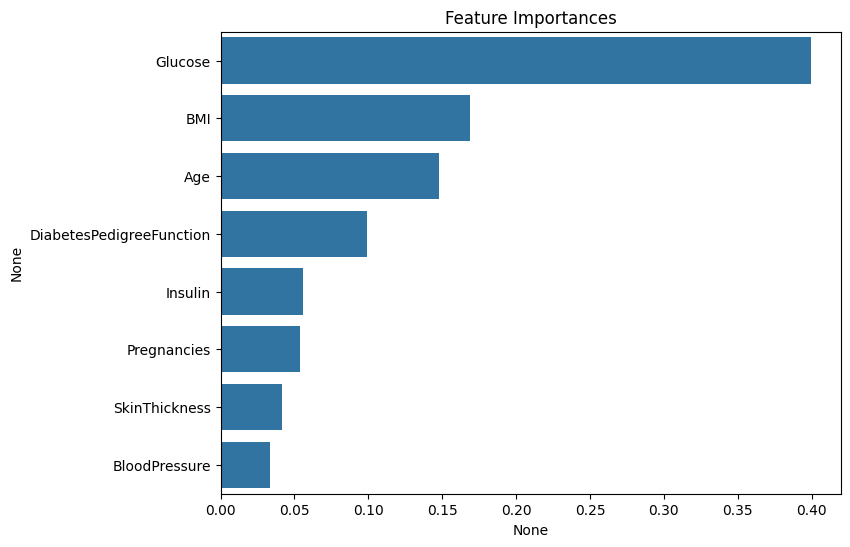

In [5]:

# Final Evaluation
pred = best_rf.predict(X_test)
pred_proba = best_rf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, pred)
recall = recall_score(y_test, pred)
roc_auc = roc_auc_score(y_test, pred_proba)

print(f"Final Test Scores -> Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, AUC: {roc_auc:.4f}")

# Feature Importance
ftr_importances_values = best_rf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)

plt.figure(figsize=(8, 6))
plt.title('Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()



### 💡 Intermediate Conclusion (Step 5)
1. **Glucose**: 예상대로 혈당(Glucose)이 압도적으로 가장 중요한 변수로 나타났습니다.
2. **BMI & Age**: 그 다음으로 비만도와 나이가 중요한 요인입니다.



## 6단계: AI 기반 통합 분석 (Macro-Analysis) [사용자 수행 단계]

이 단계는 **Google NotebookLM**을 활용하여 본 분석 결과와 다른 노트북들을 통합하여 인사이트를 도출하는 과정입니다.

### ✅ Action Checklist
1. **Save Output**: 현재 노트북의 모든 셀이 실행되어 Output(그래프, 통계 수치)이 정상적으로 보이는지 확인하고 저장(Save)합니다.
2. **Upload**: NotebookLM에 이 파일(`EDA_01_Diabetes_Analysis.ipynb`)을 업로드합니다.
3. **Prompting**: 다음과 같은 질문을 던져보세요.
    > "타이타닉 데이터의 생존 요인과 당뇨병 발병 요인 간에 구조적인 공통점(예: 나이의 영향력 등)이 있는지 비교 분석해줘."
    > "이 모델의 Recall(재현율)을 더 높이기 위해 어떤 전략을 제안할 수 있는지 논문이나 통계적 지식을 기반으로 조언해줘."
